In [19]:
# Using simplegmail abstraction instead of writing gmail logic from scratch
# https://github.com/jeremyephron/simplegmail
from simplegmail import Gmail, query
# langchain
from langchain_community.llms import Ollama
from langchain import PromptTemplate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [30]:
# Get gmail service - check https://github.com/jeremyephron/simplegmail
# may need to authenticate - keep credentials ready
gmail = Gmail()

In [29]:
# Ollama has to be running seperately with the model specified pulled and ready
llm = Ollama(model="llama3.1:latest", stop=["<|eot_id|>"]) # Added stop token

In [4]:
def get_model_response(user_prompt, system_prompt):
    # NOTE: No f string and no whitespace in curly braces
    template = """
        <|begin_of_text|>
        <|start_header_id|>system<|end_header_id|>
        {system_prompt}
        <|eot_id|>
        <|start_header_id|>user<|end_header_id|>
        {user_prompt}
        <|eot_id|>
        <|start_header_id|>assistant<|end_header_id|>
        """

    # Added prompt template
    prompt = PromptTemplate(
        input_variables=["system_prompt", "user_prompt"],
        template=template
    )
    
    # invoking the model
    response = llm.invoke(prompt.format(system_prompt=system_prompt, user_prompt=user_prompt))
    
    return response

In [5]:
# Get mails from past _ units
numberOf = 1
messages = gmail.get_messages(query=query.construct_query(newer_than=(numberOf, "day"), labels=[["INBOX"]]))

In [6]:
from bs4 import BeautifulSoup

def get_text_from_html(html: str):
    """ extract plain text from html """
    soup = BeautifulSoup(html, features="html.parser")
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()    # rip it out
    # get text
    return soup.body.get_text(separator='\n', strip=True)

In [ ]:
froms = [message.sender for message in messages]
ids = [message.id for message in messages]
dates = [message.date for message in messages]
subjects = [message.subject for message in messages]
bodies = []
print(f'Total messages: {len(messages)}')
for message in messages:
    print(f"""--- from: {message.sender} date:{message.date} ---
        subject: {message.subject}""")
    content = message.plain if message.plain else get_text_from_html(message.html) if message.html else 'No content - answer N/A'
    bodies.append(content)
df = pd.DataFrame({
    'id':ids,
    'date':dates,
    'from':froms,
    'subject':subjects,
    'body':bodies
})
total = len(df.index)
df['result'] = ['-'] * total

In [32]:
system_mail_prompt = """You are an expert email assistant wizard. You are given the body of an email I recieved. Provide a simple Yes or No answer to the question - \"Is this email I recieved regarding a SOFTWARE JOB APPLICATION that I applied for?\" 
Think step by step. Look for job related infromation like job title, company name etc. Then decide your answer. You don\'t have to provide a long answer. Just a simple \"Yes\" or \"No\".
Check the answer you generated. If it is not a \"Yes\" or \"No\", think whether this is \"Yes\" or \"No\"."""
# user_mail_prompt = """"""

In [ ]:
print(f'Total messages: {len(df.index)}')
for row in df.itertuples():
    if row[6].lower() in ['yes', 'yes.', 'no', 'no.']:
        continue
    glance = f"""from:{row[3]}, date:{row[2]}
    subject:{row[4]}
    """
    print(glance)
    content = glance + row[5]
    result = get_model_response(user_prompt=content, system_prompt=system_mail_prompt)
    df.at[row.Index, 'result'] = result
df

In [42]:
yes = len(df[df['result'] == 'Yes']) + len(df[df['result'] == 'Yes.'])
no = len(df[df['result'] == 'No']) + len(df[df['result'] == 'No.'])
neither = total - (yes + no)
print(f'{yes=}\n{no=}\n{neither=}')

yes=24
no=11
neither=3


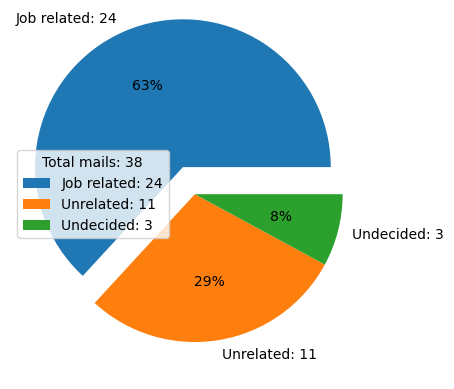

In [43]:
y = np.array([yes, no, neither])
lables = [f'Job related: {yes}', f'Unrelated: {no}', f'Undecided: {neither}']
explode = [0.2, 0, 0]
plt.pie(y, autopct='%1.0f%%', labels=lables, explode=explode)
plt.legend(title=f'Total mails: {total}')
plt.show() 